This a brief tutorial to use HDP-GPC, a dynamic clustering library. 
As a summary of the objectives of this notebook:
1. Learn to load some public data and learn how compute the initial statistics.
2. Learn to define the model and check each one of the hyperparameters' configuration.
3. Learn to execute inference and how this can be tuned.
4. Learn how to plot the results and study the dynamic parameters.

We should first import the main packages to deal with the data:

In [1]:
import numpy as np
import torch
import os

Now we can load the data, to illustrate this example we are going to reduce the data to examples from 1700 to 1950.

In [3]:
cwd = os.path.dirname(os.getcwd())
data_path = os.path.join(cwd, 'data', 'ocean', 'BBDD_Adrian')
data = np.load(os.path.join(data_path, 'data.npy'))
freq = np.load(os.path.join(data_path, 'freq.npy'))
#labels = np.load(os.path.join(data_path, '100_labels.npy'))

print("Shape of the data: ")
print(data.shape)
num_samples, num_obs_per_sample, num_outputs = data.shape

Shape of the data: 
(14376, 171, 1)


The data dimensions correspond with [number of examples, number of observations, number of outputs]. Let's check how looks this data:

(171,)


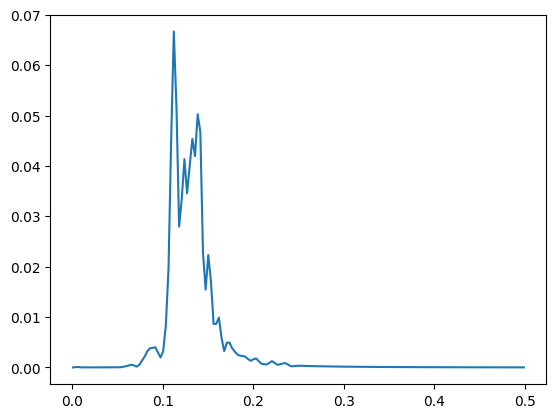

In [4]:
import matplotlib.pyplot as plt
print(freq.shape)
plt.plot(freq, data[0,:,0])
plt.show()

As we can see, it corresponds to a heartbeat. This is the kind of patterns we want to cluster over the record.
To compute the initial statistics we are going to use the observation variance and the 1-step rolled variance.
For that, we have a method in the get_data class, where we can choose the batch to compute this statistics.

In [15]:
from hdpgpc.get_data import compute_estimators_LDS

std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(data, n_f=50)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 0.1
std_dif = std_dif * 0.1
bound_sigma = (std * 1e-7, std * 1e-6)
bound_gamma = (std_dif * 1e-9, std_dif * 1e-8)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)


Sigma estimated: 0.0005476619942334498
Gamma estimated: 0.0005476619942334498
Final sigma: 5.476619942334498e-05
Final gamma: 5.476619942334498e-05
Final sigma bound: (5.4766199423344976e-12, 5.476619942334498e-11)
Final gamma bound: (5.476619942334499e-14, 5.476619942334499e-13)


As we can see, the 1-step variance is higher than the variance, which indicates a slight dynamic behaviour.

Now we can define the HDP-GPC model. 

The hyperparameters can be directly estimated from the previously computed estimators. As a standard an initial M has to be chosen, as a default, it is chosen as M=2 as the model computes the needed number of clusters as it progresses in the inference.


In [16]:
M = 2
sigma = [std * 1.0] * M
gamma = [std_dif * 1.0] * M

We can also define the kernel parameters, in this case we are taking outputscale = 300.0 as is the mean amplitude found on a standard record of ECG. Also, we are choosing ini_legthscale = 1.0 as a standard value. Both can be tuned, but they do not have a critical impact on the inference because they are optimized in terms of Maximum-Likelihood.

In [17]:
outputscale_ = 0.1
ini_lengthscale = 1e-4
bound_lengthscale = (1e-7, 1e-3)

Also, we have to define the time indexes where the observations had been taken, which is x_train. In this case it can be as simple as a range of the same length of the observations, but it can differ along the samples. On the other hand, we have to define x_basis, which is the time index basis where the LDS is going to be computed (it fix the dimension of the LDS) If desired, the x_basis can be reduced to be a set of inducing points. If this dimensional reduction is applied it should be reflected in the option parameter inducing_points=True. 

In [18]:
samples = [0, num_obs_per_sample]
l, L = samples[0], samples[1]
# x_basis has to have the same dimension structure as data[0], in this case (171,1) but it could be (n_inducing_points, 1).
x_basis = np.atleast_2d(freq).T
x_train = np.atleast_2d(freq).T
print(x_train.shape)
#If x_basis is wanted to be smaller than the observations length, then the inducing points approach can be applied setting this parameter to True.
inducing_points = False

(171, 1)


Additionally, we can also define the warp GP hyperparameters and time indexes. 

In [19]:
#Choose if warp is going to be applied. (In the most recent version is optimized to work with online inference, but it can be used in offline as an additional step at the end of the clustering).
warp = False
#Warp priors
noise_warp = std * 0.1
bound_noise_warp = (noise_warp * 0.1, noise_warp * 0.2)
#Warp time indexes
x_basis_warp = np.atleast_2d(np.arange(freq[0], freq[-1], freq.shape[0]/2.0, dtype=np.float64)).T

Finally, with these parameters we can define the HDP-GPC. 
There exist a lot of configuration parameters that can be combined in this model, to check the options and the relevance of these configuration options go to the Documentation (in progress).

In terms of define the model, we should consider the inference method we want to apply because each one have their restrictions (by now).

1. In first place we have the online inference, where we can include one sample at a time and let the model cluster it. By now, the online inference only works with one output signal, but it is going to be extended soon. That's why we choose n_outputs=1.

In [20]:
import hdpgpc.GPI_HDP as hdpgp

sw_gp = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=1,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=True, max_models=100, inducing_points=inducing_points, estimation_limit=30)

We can revise the priors that had been defined for our model.  The cluster list of GP-LDS is generated inside the model, indexes as gpmodels[n_output][n_cluster]. We can plot the zero-knowledge cluster.

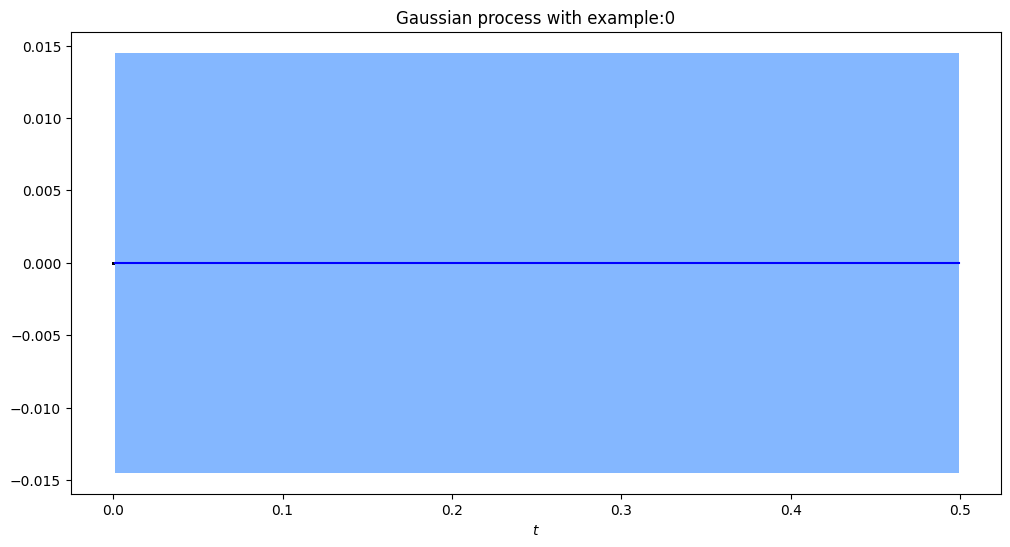

In [21]:
sw_gp.gpmodels[0][0].plot_last(0)

In [22]:
data_ = data[:,:,[0]]
sw_gp.include_sample(x_train, data_[0], with_warp=warp)

Main model chosen: 1

 Fitting_GP: 

Iter 1/4000 - Loss: 1186691.255
Iter 501/4000 - Loss: -1.485
Iter 1001/4000 - Loss: -1.535
Iter 1501/4000 - Loss: -1.611
Iter 2001/4000 - Loss: -1.714
Iter 2501/4000 - Loss: -1.841
Iter 3001/4000 - Loss: -1.954
Iter 3501/4000 - Loss: -1.999


Parameter name: likelihood.noise_covar.raw_noise           value = [2.55579532]
Parameter name: mean_module.raw_constant                   value = 0.003871941813916027
Parameter name: covar_module.raw_outputscale               value = 2.903089170102015
Parameter name: covar_module.base_kernel.raw_lengthscale   value = [[-4.96257866]]
---Kernel estimated---
1.72**2 * RBF(length_scale=0.00697) + WhiteKernel(noise_level=5.12e-11)


Now the first example has been included in the model. 
We can check some parameters to be sure the sample has been added:

Kernel estimated: 1.72**2 * RBF(length_scale=0.00697) + WhiteKernel(noise_level=5.12e-11)
Model 1 : MainModel: N : [N-1]
Model 2  : []
Classification error:  0.0 / 1 -- 0.0


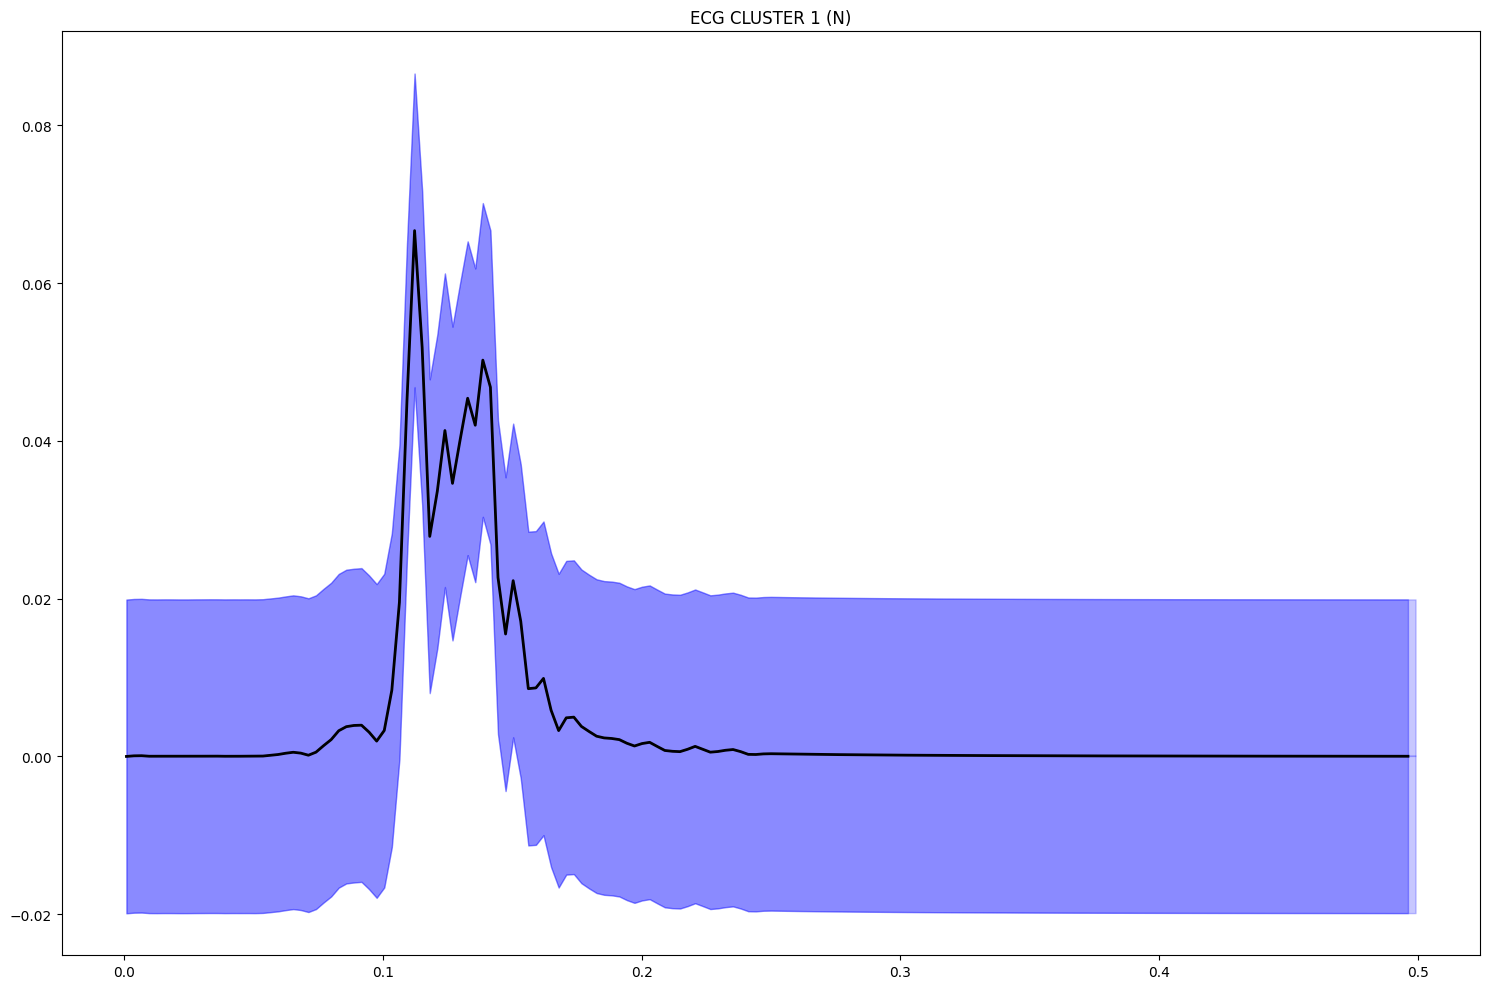

In [23]:
print("Kernel estimated:", sw_gp.gpmodels[0][0].gp.kernel)

#Generate artificial labels to plot using util_plots.
from hdpgpc.util_plots import print_results, plot_models_plotly
labels = np.array(['N'] * data.shape[0])
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, labels, main_model, N_0=0, lead=0, step=freq[1]-freq[0], plot_latent=True, ticks=True)

As we can see, the sample had been added successfully and the GP performed regression over it. Now we can include more samples, in this case, we are adding 100 to check how fast is the computation without warp component.

In [19]:
import time

for j, d in enumerate(data_[1:40]):
    start_time = time.time()
    print("Sample:", j+1, "/", str(data_.shape[0]-1), "label:", labels[j+1])
    sw_gp.include_sample(x_train, d, with_warp=warp)
    print("Time --- %s seconds ---" % (time.time() - start_time))

Sample: 1 / 14375 label: N
Birth of new model:  2
Main model chosen: 2

 Fitting_GP: 

Iter 1/4000 - Loss: 1.617
Iter 501/4000 - Loss: -4.196
Iter 1001/4000 - Loss: -4.872


Parameter name: likelihood.noise_covar.raw_noise           value = [-7.32294039]
Parameter name: mean_module.raw_constant                   value = 0.0025960308592559173
Parameter name: covar_module.raw_outputscale               value = -9.878841331554167
Parameter name: covar_module.base_kernel.raw_lengthscale   value = [[-5.29564128]]
Time --- 7.234885215759277 seconds ---
Sample: 2 / 14375 label: N
Main model chosen: 2
Time --- 0.07639026641845703 seconds ---
Sample: 3 / 14375 label: N
Main model chosen: 2
Time --- 0.07978677749633789 seconds ---
Sample: 4 / 14375 label: N
Birth of new model:  3
Main model chosen: 3

 Fitting_GP: 

Iter 1/4000 - Loss: 14.157
Iter 501/4000 - Loss: -3.957
Iter 1001/4000 - Loss: -3.960


Parameter name: likelihood.noise_covar.raw_noise           value = [3.0298388]
Parameter name: 

The clustering has generated a bunch of clusters. Let's revise them using the util_plot methods. Here the difference between groups is clearer:

Model 1 : MainModel: N : [N-2]
Model 2 : MainModel: N : [N-5]
Model 3 : MainModel: N : [N-1]
Model 4 : MainModel: N : [N-2]
Model 5 : MainModel: N : [N-2]
Model 6 : MainModel: N : [N-1]
Model 7 : MainModel: N : [N-1]
Model 8 : MainModel: N : [N-1]
Model 9 : MainModel: N : [N-1]
Model 10 : MainModel: N : [N-1]
Model 11 : MainModel: N : [N-1]
Model 12 : MainModel: N : [N-1]
Model 13 : MainModel: N : [N-1]
Model 14 : MainModel: N : [N-1]
Model 15 : MainModel: N : [N-1]
Model 16 : MainModel: N : [N-1]
Model 17 : MainModel: N : [N-1]
Model 18 : MainModel: N : [N-1]
Model 19 : MainModel: N : [N-1]
Model 20 : MainModel: N : [N-1]
Model 21 : MainModel: N : [N-1]
Model 22 : MainModel: N : [N-1]
Model 23 : MainModel: N : [N-1]
Model 24 : MainModel: N : [N-1]
Model 25 : MainModel: N : [N-1]
Model 26 : MainModel: N : [N-1]
Model 27 : MainModel: N : [N-1]
Model 28 : MainModel: N : [N-1]
Model 29 : MainModel: N : [N-1]
Model 30 : MainModel: N : [N-1]
Model 31 : MainModel: N : [N-1]
Model 32 : MainMo

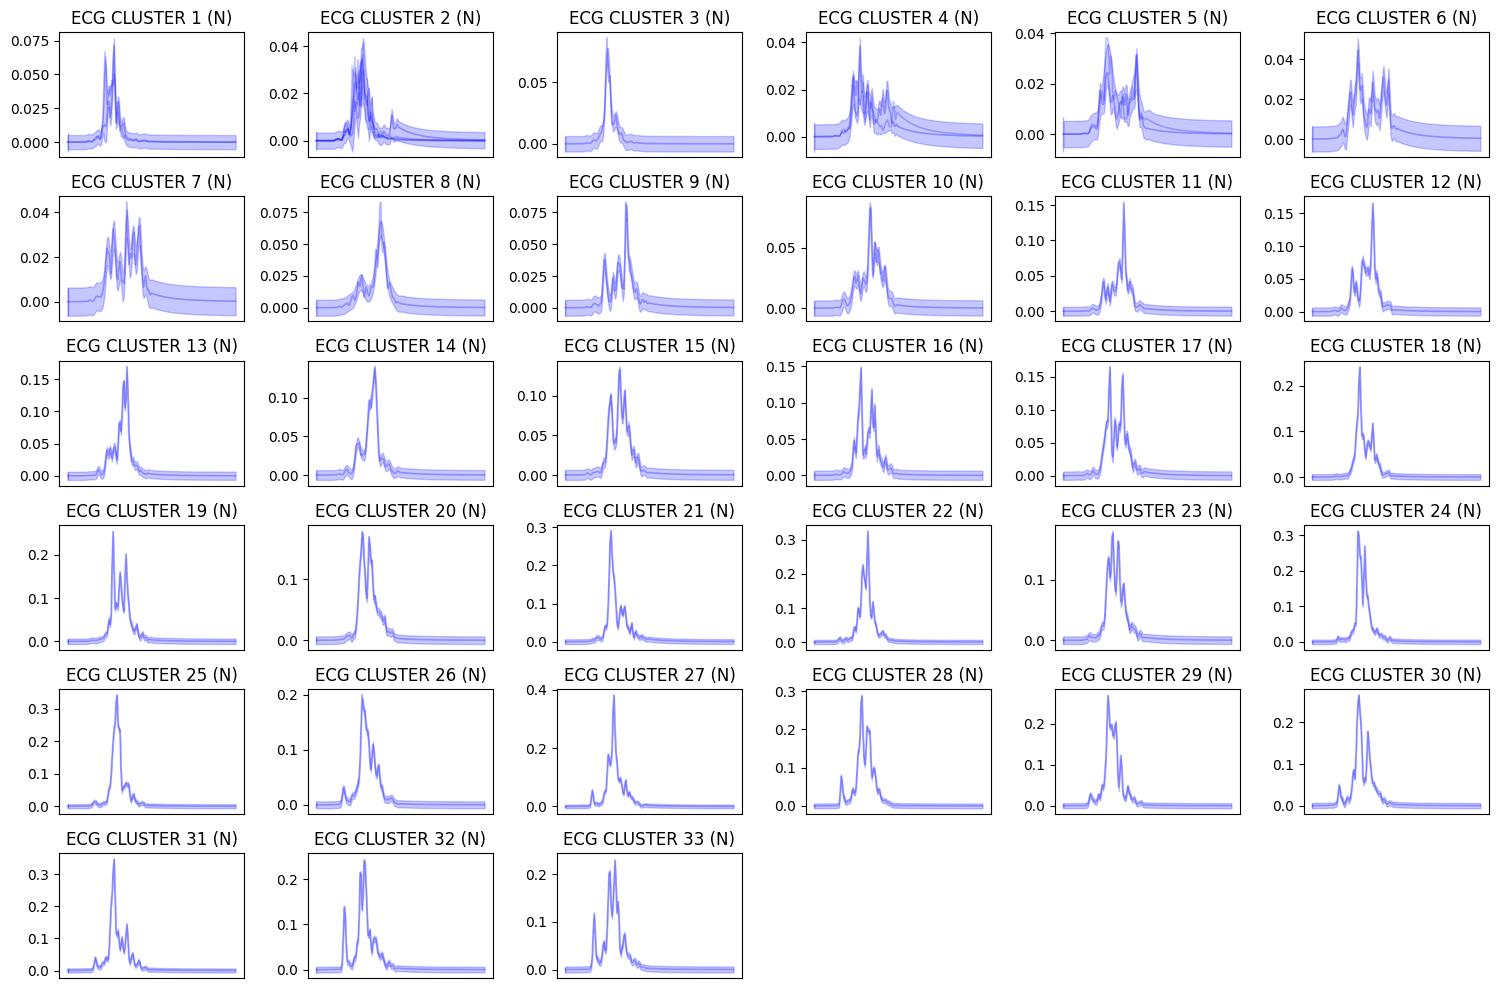

In [20]:
from hdpgpc.util_plots import print_results, plot_models_plotly

main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=0.5, plot_latent=True)

If we try to include the examples from 1900 to 1950, knowing that a ventricular beat exist among them, we are going to check if the model generates a new group.

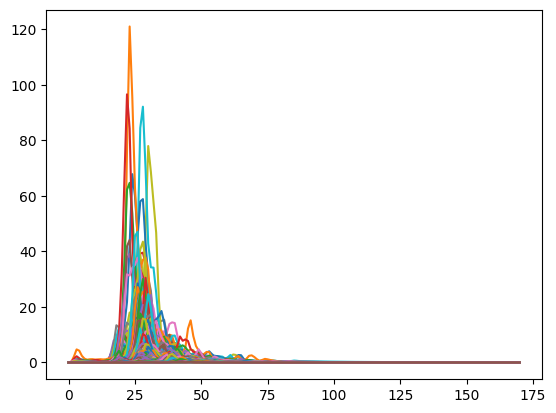

In [21]:
plt.plot(data_[200:,:,0].T)
plt.show()


In [ ]:

for j, d in enumerate(data_[200:]):
    start_time = time.time()
    print("Sample:", j + 200, "/", str(data_.shape[0]-1), "label:", labels[j+200])
    sw_gp.include_sample(x_train, d, with_warp=warp)
    print("Time --- %s seconds ---" % (time.time() - start_time))

In [ ]:
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=0.5, plot_latent=True)

As expected, the ventricular beat generated a cluster itself.

To perform the same clustering but in an offline scheme, we only have to choose the offline inference method, we are going to use it with full record. Here are some new option parameters: reestimate_initial_params indicates when a reestimation for the prior LDS is desired (it is recommended in the offline setting), n_explore_steps indicates the number of tryals to generate a new group on each iteration, recommended is above 10, but in this case to make the clustering faster, 3 will be enough. This full clustering takes a bit longer.

In [25]:
sw_gp = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=1,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=True, max_models=100, inducing_points=inducing_points, reestimate_initial_params=False,
                          n_explore_steps=5)

data = np.load(os.path.join(data_path, 'data.npy'))
freq = np.load(os.path.join(data_path, 'freq.npy'))
num_samples = data.shape[0]
x_trains = np.array([x_train] * 200)
sw_gp.include_batch(x_trains, data[:200,:,[0]])


Group responsability estimated: [200   0]


Forward_pass:   0%|          | 0/200 [00:00<?, ?it/s]


 Fitting_GP: 

Iter 1/4000 - Loss: 11.317
Iter 501/4000 - Loss: -3.948
Iter 1001/4000 - Loss: -3.946


Forward_pass:   4%|▎         | 7/200 [00:07<02:33,  1.26it/s]



Parameter name: likelihood.noise_covar.raw_noise           value = [2.00452608]
Parameter name: mean_module.raw_constant                   value = 0.008008392062892066
Parameter name: covar_module.raw_outputscale               value = -9.232384285485388
Parameter name: covar_module.base_kernel.raw_lengthscale   value = [[-5.12053624]]


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 506.38it/s]



-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 517.81it/s]


Step 1/5- Trying to divide: 0 with beat 70


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 600.21it/s]


Sum resp_temp: tensor([195.,   5.])
Q_bas: tensor(-12610.6727)
Q_bas_post: tensor(-13035.4294)
Chosen to divide: 0 with beat 70
First resp: tensor([195.,   5.])

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------
Current resp: tensor([195.,   5.])
ELBO_reduction: 0.0
Mean_sq: tensor(-13035.4294)
ELBO: tensor([-46473.3348])

-------Lower Bound Iteration 1-------
Group responsability estimated: [195   5]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 401.10it/s]



-----------Lead 1-----------

   -----------Model 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 475.22it/s]



   -----------Model 2-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 433.51it/s]



   -----------Model 3-----------
Sum resp_temp: tensor([184.,  16.,   0.])
Q_bas: tensor(-13035.4294)
Q_bas_post: tensor(-12654.1472)
Reallocating beats into existing groups.
First resp: tensor([184.,  16.,   0.])
Mean_sq: tensor(-12654.1472)
ELBO: tensor([-44768.4424])

-------Lower Bound Iteration 2-------
Group responsability estimated: [184  16   0]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 449.51it/s]



-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------
Sum resp_temp: tensor([184.,  16.,   0.])
Q_bas: tensor(-12654.1472)
Q_bas_post: tensor(-12654.1472)
Not reallocating, trying to generate new group.
Step 1/5- Trying to divide: 0 with beat 51


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 345.55it/s]


Sum resp_temp: tensor([161.,  23.,  16.])
Q_bas: tensor(-12654.1472)
Q_bas_post: tensor(-12643.5385)
Chosen to divide: 0 with beat 51
First resp: tensor([161.,  23.,  16.])

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------
Current resp: tensor([161.,  23.,  16.])
ELBO_reduction: 0.0
Mean_sq: tensor(-12643.5385)
ELBO: tensor([-41750.0745])

-------Lower Bound Iteration 3-------
Group responsability estimated: [161  23  16]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 373.69it/s]



-----------Lead 1-----------

   -----------Model 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 577.39it/s]



   -----------Model 2-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 398.23it/s]



   -----------Model 3-----------

   -----------Model 4-----------
Sum resp_temp: tensor([161.,  23.,  16.,   0.])
Q_bas: tensor(-12643.5385)
Q_bas_post: tensor(-12650.7086)
Not reallocating, trying to generate new group.
Step 1/5- Trying to divide: 2 with beat 70


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 598.61it/s]


Sum resp_temp: tensor([161.,  23.,  14.,   2.])
Q_bas: tensor(-12643.5385)
Q_bas_post: tensor(-12984.5726)
Chosen to divide: 2 with beat 70
First resp: tensor([161.,  23.,  14.,   2.])

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------
Current resp: tensor([161.,  23.,  14.,   2.])
ELBO_reduction: 0.0
Mean_sq: tensor(-12984.5726)
ELBO: tensor([-41746.0517])

-------Lower Bound Iteration 4-------
Group responsability estimated: [161  23  14   2]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 420.32it/s]



-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------
Sum resp_temp: tensor([161.,  23.,  14.,   2.,   0.])
Q_bas: tensor(-12984.5726)
Q_bas_post: tensor(-12984.5726)
Not reallocating, trying to generate new group.
Step 1/5- Trying to divide: 0 with beat 55


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 641.33it/s]


Sum resp_temp: tensor([157.,  20.,  14.,   7.,   2.])
Q_bas: tensor(-12984.5726)
Q_bas_post: tensor(-13258.1998)
Chosen to divide: 0 with beat 55
First resp: tensor([157.,  20.,  14.,   7.,   2.])

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------
Current resp: tensor([157.,  20.,  14.,   7.,   2.])
ELBO_reduction: 0.0
Mean_sq: tensor(-13258.1998)
ELBO: tensor([-40955.8432])

-------Lower Bound Iteration 5-------
Group responsability estimated: [157  20  14   7   2]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 614.98it/s]



-----------Lead 1-----------

   -----------Model 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 623.94it/s]



   -----------Model 2-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 585.38it/s]



   -----------Model 3-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 511.48it/s]



   -----------Model 4-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 566.41it/s]



   -----------Model 5-----------

   -----------Model 6-----------
Sum resp_temp: tensor([152.,  19.,  17.,  10.,   2.,   0.])
Q_bas: tensor(-13258.1998)
Q_bas_post: tensor(-13143.7397)
Reallocating beats into existing groups.
First resp: tensor([152.,  19.,  17.,  10.,   2.,   0.])
Mean_sq: tensor(-13143.7397)
ELBO: tensor([-40527.2204])

-------Lower Bound Iteration 6-------
Group responsability estimated: [152  19  17  10   2   0]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 476.19it/s]



-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------
Sum resp_temp: tensor([152.,  19.,  17.,  10.,   2.,   0.])
Q_bas: tensor(-13143.7397)
Q_bas_post: tensor(-13143.7397)
Not reallocating, trying to generate new group.
Step 1/5- Trying to divide: 1 with beat 28


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 528.47it/s]


Sum resp_temp: tensor([152.,  16.,  16.,  10.,   4.,   2.])
Q_bas: tensor(-13143.7397)
Q_bas_post: tensor(-13310.9773)
Chosen to divide: 1 with beat 28
First resp: tensor([152.,  16.,  16.,  10.,   4.,   2.])

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------
Current resp: tensor([152.,  16.,  16.,  10.,   4.,   2.])
ELBO_reduction: 0.0
Mean_sq: tensor(-13310.9773)
ELBO: tensor([-40098.7562])

-------Lower Bound Iteration 7-------
Group responsability estimated: [152  16  16  10   4   2]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 615.36it/s]



-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 499.83it/s]



   -----------Model 3-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 516.65it/s]



   -----------Model 4-----------

   -----------Model 5-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 694.40it/s]



   -----------Model 6-----------

   -----------Model 7-----------
Sum resp_temp: tensor([152.,  17.,  12.,  10.,   7.,   2.,   0.])
Q_bas: tensor(-13310.9773)
Q_bas_post: tensor(-13323.6847)
Reallocating beats into existing groups.
First resp: tensor([152.,  17.,  12.,  10.,   7.,   2.,   0.])
Mean_sq: tensor(-13323.6847)
ELBO: tensor([-39894.4843])

-------Lower Bound Iteration 8-------
Group responsability estimated: [152  17  12  10   7   2   0]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 455.16it/s]



-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------
Sum resp_temp: tensor([152.,  17.,  12.,  10.,   7.,   2.,   0.])
Q_bas: tensor(-13323.6847)
Q_bas_post: tensor(-13323.6847)
Not reallocating, trying to generate new group.
Step 1/5- Trying to divide: 3 with beat 60


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 501.07it/s]


Sum resp_temp: tensor([152.,  17.,  12.,   8.,   7.,   2.,   2.])
Q_bas: tensor(-13323.6847)
Q_bas_post: tensor(-13387.5564)
Chosen to divide: 3 with beat 60
First resp: tensor([152.,  17.,  12.,   8.,   7.,   2.,   2.])

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------
Current resp: tensor([152.,  17.,  12.,   8.,   7.,   2.,   2.])
ELBO_reduction: 0.0
Mean_sq: tensor(-13387.5564)
ELBO: tensor([-39774.3180])

-------Lower Bound Iteration 9-------
Group responsability estimated: [152  17  12   8   7   2   2]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 502.05it/s]



-----------Lead 1-----------

   -----------Model 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 529.35it/s]



   -----------Model 2-----------


Compute_sq_error: 100%|██████████| 200/200 [00:01<00:00, 167.61it/s]



   -----------Model 3-----------

   -----------Model 4-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 447.08it/s]



   -----------Model 5-----------

   -----------Model 6-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 593.40it/s]



   -----------Model 7-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 366.39it/s]



   -----------Model 8-----------
Sum resp_temp: tensor([151.,  16.,  12.,   7.,   7.,   6.,   1.,   0.])
Q_bas: tensor(-13387.5564)
Q_bas_post: tensor(-13214.4078)
Reallocating beats into existing groups.
First resp: tensor([151.,  16.,  12.,   7.,   7.,   6.,   1.,   0.])
Mean_sq: tensor(-13214.4078)
ELBO: tensor([-39428.7506])

-------Lower Bound Iteration 10-------
Group responsability estimated: [151  16  12   7   7   6   1   0]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 442.57it/s]



-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------
Sum resp_temp: tensor([151.,  16.,  12.,   7.,   7.,   6.,   1.,   0.])
Q_bas: tensor(-13214.4078)
Q_bas_post: tensor(-13214.4078)
Not reallocating, trying to generate new group.
Step 1/5- Trying to divide: 4 with beat 28


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 519.57it/s]


Sum resp_temp: tensor([151.,  15.,  12.,   7.,   6.,   5.,   3.,   1.])
Q_bas: tensor(-13214.4078)
Q_bas_post: tensor(-13623.5258)
Step 2/5- Trying to divide: 0 with beat 42


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 238.36it/s]


Sum resp_temp: tensor([149.,  11.,  11.,   8.,   7.,   7.,   6.,   1.])
Q_bas: tensor(-13214.4078)
Q_bas_post: tensor(-13329.8670)
Chosen to divide: 0 with beat 42
First resp: tensor([149.,  11.,  11.,   8.,   7.,   7.,   6.,   1.])

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------
Current resp: tensor([149.,  11.,  11.,   8.,   7.,   7.,   6.,   1.])
ELBO_reduction: 0.0
Mean_sq: tensor(-13329.8670)
ELBO: tensor([-38974.0327])

-------Lower Bound Iteration 11-------
Group responsability estimated: [149  11  11   8   7   7   6   1]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:01<00:00, 189.43it/s]



-----------Lead 1-----------

   -----------Model 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 213.91it/s]



   -----------Model 2-----------


Compute_sq_error: 100%|██████████| 200/200 [00:01<00:00, 170.58it/s]



   -----------Model 3-----------

   -----------Model 4-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 254.30it/s]



   -----------Model 5-----------

   -----------Model 6-----------


Compute_sq_error: 100%|██████████| 200/200 [00:01<00:00, 167.21it/s]



   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------
Sum resp_temp: tensor([145.,  15.,  11.,   9.,   7.,   6.,   6.,   1.,   0.])
Q_bas: tensor(-13329.8670)
Q_bas_post: tensor(-13391.0493)
Reallocating beats into existing groups.
First resp: tensor([145.,  15.,  11.,   9.,   7.,   6.,   6.,   1.,   0.])
Mean_sq: tensor(-13391.0493)
ELBO: tensor([-38608.1232])

-------Lower Bound Iteration 12-------
Group responsability estimated: [145  15  11   9   7   6   6   1   0]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 312.16it/s]



-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------
Sum resp_temp: tensor([145.,  15.,  11.,   9.,   7.,   6.,   6.,   1.,   0.])
Q_bas: tensor(-13391.0493)
Q_bas_post: tensor(-13391.0493)
Not reallocating, trying to generate new group.
Step 1/5- Trying to divide: 5 with beat 28


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 446.01it/s]


Sum resp_temp: tensor([145.,  15.,  11.,   9.,   7.,   6.,   5.,   1.,   1.])
Q_bas: tensor(-13391.0493)
Q_bas_post: tensor(-13782.4459)
Step 2/5- Trying to divide: 0 with beat 78


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 505.40it/s]


Sum resp_temp: tensor([141.,  15.,  11.,   9.,   8.,   6.,   6.,   3.,   1.])
Q_bas: tensor(-13391.0493)
Q_bas_post: tensor(-13516.9158)
Chosen to divide: 0 with beat 78
First resp: tensor([141.,  15.,  11.,   9.,   8.,   6.,   6.,   3.,   1.])

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------
Current resp: tensor([141.,  15.,  11.,   9.,   8.,   6.,   6.,   3.,   1.])
ELBO_reduction: 0.0
Mean_sq: tensor(-13516.9158)
ELBO: tensor([-38102.2553])

-------Lower Bound Iteration 13-------
Group responsability estimated: [141  15  11   9   8   6   6   3   1]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 601.57it/s]



-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------
Sum resp_temp: tensor([141.,  15.,  11.,   9.,   8.,   6.,   6.,   3.,   1.,   0.])
Q_bas: tensor(-13516.9158)
Q_bas_post: tensor(-13516.9158)
Not reallocating, trying to generate new group.
Step 1/5- Trying to divide: 6 with beat 28


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 224.69it/s]


Sum resp_temp: tensor([141.,  15.,  11.,   9.,   8.,   6.,   5.,   3.,   1.,   1.])
Q_bas: tensor(-13516.9158)
Q_bas_post: tensor(-13908.3123)
Step 2/5- Trying to divide: 6 with beat 39


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 311.50it/s]


Sum resp_temp: tensor([141.,  15.,   9.,   9.,   8.,   6.,   4.,   4.,   3.,   1.])
Q_bas: tensor(-13516.9158)
Q_bas_post: tensor(-13599.1016)
Chosen to divide: 6 with beat 39
First resp: tensor([141.,  15.,   9.,   9.,   8.,   6.,   4.,   4.,   3.,   1.])

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------
Current resp: tensor([141.,  15.,   9.,   9.,   8.,   6.,   4.,   4.,   3.,   1.])
ELBO_reduction: 0.0
Mean_sq: tensor(-13599.1016)
ELBO: tensor([-37896.7397])

-------Lower Bound Iteration 14-------
Group responsability estimated: [141  15   9   9   8   6   4   4   3   1]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 485.69it/s]



-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------
Sum resp_temp: tensor([141.,  15.,   9.,   9.,   8.,   6.,   4.,   4.,   3.,   1.,   0.])
Q_bas: tensor(-13599.1016)
Q_bas_post: tensor(-13599.1016)
Not reallocating, trying to generate new group.
Step 1/5- Trying to divide: 1 with beat 19


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 409.40it/s]


Sum resp_temp: tensor([137.,  12.,   9.,   8.,   8.,   8.,   6.,   4.,   4.,   3.,   1.])
Q_bas: tensor(-13599.1016)
Q_bas_post: tensor(-13692.3711)
Chosen to divide: 1 with beat 19
First resp: tensor([137.,  12.,   9.,   8.,   8.,   8.,   6.,   4.,   4.,   3.,   1.])

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------
Current resp: tensor([137.,  12.,   9.,   8.,   8.,   8.,   6.,   4.,   4.,   3.,   1.])
ELBO_reduction: 0.0
Mean_sq: tensor(-13692.3711)
ELBO: tensor([-37256.5837])

-------Lower Bound Iteration 15-------
Group responsability estimated: [137  12   9   8   8   8   6   4   4   3   1]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:02<00:00, 68.97it/s] 



-----------Lead 1-----------

   -----------Model 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 429.15it/s]



   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 386.01it/s]



   -----------Model 6-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 379.17it/s]



   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------

   -----------Model 12-----------
Sum resp_temp: tensor([139.,  12.,   9.,   8.,   8.,   6.,   6.,   4.,   4.,   3.,   1.,   0.])
Q_bas: tensor(-13692.3711)
Q_bas_post: tensor(-13721.1630)
Not reallocating, trying to generate new group.
Step 1/5- Trying to divide: 7 with beat 28


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 207.90it/s]


Sum resp_temp: tensor([139.,  12.,   9.,   8.,   8.,   6.,   6.,   4.,   3.,   3.,   1.,   1.])
Q_bas: tensor(-13692.3711)
Q_bas_post: tensor(-14105.5946)
Step 2/5- Trying to divide: 5 with beat 17


Compute_sq_error: 100%|██████████| 200/200 [00:01<00:00, 146.64it/s]


Sum resp_temp: tensor([134.,  12.,   9.,   9.,   8.,   6.,   6.,   4.,   4.,   4.,   3.,   1.])
Q_bas: tensor(-13692.3711)
Q_bas_post: tensor(-13716.2708)
Chosen to divide: 5 with beat 17
First resp: tensor([134.,  12.,   9.,   9.,   8.,   6.,   6.,   4.,   4.,   4.,   3.,   1.])

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------

   -----------Model 12-----------
Current resp: tensor([134.,  12.,   9.,   9.,   8.,   6.,   6.,   4.,   4.,   4.,   3.,   1.])
ELBO_reduction: 0.0
Mean_sq: tensor(-13716.2708)
ELBO: tensor([-36732.1359])

-------Lower Bound Iteration 16-------
Group responsability estimated: [134  12   9   9   8   6   6   4  

Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 463.31it/s]



-----------Lead 1-----------

   -----------Model 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 600.68it/s]



   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 517.98it/s]



   -----------Model 6-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 466.15it/s]



   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------

   -----------Model 12-----------

   -----------Model 13-----------
Sum resp_temp: tensor([133.,  12.,   9.,   8.,   7.,   7.,   6.,   6.,   4.,   4.,   3.,   1.,
          0.])
Q_bas: tensor(-13716.2708)
Q_bas_post: tensor(-13725.2146)
Reallocating beats into existing groups.
First resp: tensor([133.,  12.,   9.,   8.,   7.,   7.,   6.,   6.,   4.,   4.,   3.,   1.,
          0.])
Mean_sq: tensor(-13725.2146)
ELBO: tensor([-36435.9406])

-------Lower Bound Iteration 17-------
Group responsability estimated: [133  12   9   8   7   7   6   6   4   4   3   1   0]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 534.31it/s]



-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------

   -----------Model 12-----------

   -----------Model 13-----------
Sum resp_temp: tensor([133.,  12.,   9.,   8.,   7.,   7.,   6.,   6.,   4.,   4.,   3.,   1.,
          0.])
Q_bas: tensor(-13725.2146)
Q_bas_post: tensor(-13725.2146)
Not reallocating, trying to generate new group.
Step 1/5- Trying to divide: 8 with beat 28


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 501.07it/s]


Sum resp_temp: tensor([133.,  12.,   9.,   8.,   7.,   7.,   6.,   6.,   4.,   3.,   3.,   1.,
          1.])
Q_bas: tensor(-13725.2146)
Q_bas_post: tensor(-14109.6462)
Step 2/5- Trying to divide: 1 with beat 45


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 505.09it/s]


Sum resp_temp: tensor([133.,  10.,   9.,   8.,   7.,   7.,   6.,   6.,   4.,   4.,   3.,   2.,
          1.])
Q_bas: tensor(-13725.2146)
Q_bas_post: tensor(-13815.0548)
Chosen to divide: 1 with beat 45
First resp: tensor([133.,  10.,   9.,   8.,   7.,   7.,   6.,   6.,   4.,   4.,   3.,   2.,
          1.])

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------

   -----------Model 12-----------

   -----------Model 13-----------
Current resp: tensor([133.,  10.,   9.,   8.,   7.,   7.,   6.,   6.,   4.,   4.,   3.,   2.,
          1.])
ELBO_reduction: 0.0
Mean_sq: tensor(-13815.0548)
ELBO: tensor([-36289.4120])

-------Lower Bound Iteration

Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 480.04it/s]



-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------

   -----------Model 12-----------

   -----------Model 13-----------

   -----------Model 14-----------
Sum resp_temp: tensor([133.,  10.,   9.,   8.,   7.,   7.,   6.,   6.,   4.,   4.,   3.,   2.,
          1.,   0.])
Q_bas: tensor(-13815.0548)
Q_bas_post: tensor(-13815.0548)
Not reallocating, trying to generate new group.
Step 1/5- Trying to divide: 10 with beat 60


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 288.45it/s]


Sum resp_temp: tensor([133.,  10.,   9.,   8.,   7.,   7.,   6.,   6.,   4.,   4.,   2.,   2.,
          1.,   1.])
Q_bas: tensor(-13815.0548)
Q_bas_post: tensor(-14128.8423)
Step 2/5- Trying to divide: 8 with beat 28


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 607.93it/s]


Sum resp_temp: tensor([133.,  10.,   9.,   8.,   7.,   7.,   6.,   6.,   4.,   3.,   3.,   2.,
          1.,   1.])
Q_bas: tensor(-13815.0548)
Q_bas_post: tensor(-14199.4864)
Step 3/5- Trying to divide: 3 with beat 59


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 508.97it/s]


Sum resp_temp: tensor([133.,  10.,   9.,   7.,   7.,   6.,   6.,   5.,   4.,   4.,   3.,   3.,
          2.,   1.])
Q_bas: tensor(-13815.0548)
Q_bas_post: tensor(-13963.4320)
Chosen to divide: 3 with beat 59
First resp: tensor([133.,  10.,   9.,   7.,   7.,   6.,   6.,   5.,   4.,   4.,   3.,   3.,
          2.,   1.])

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------

   -----------Model 12-----------

   -----------Model 13-----------

   -----------Model 14-----------
Current resp: tensor([133.,  10.,   9.,   7.,   7.,   6.,   6.,   5.,   4.,   4.,   3.,   3.,
          2.,   1.])
ELBO_reduction: 0.0
Mean_sq: tensor(-13963.4320)
ELBO

Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 402.56it/s]



-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 523.74it/s]



   -----------Model 8-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 339.55it/s]



   -----------Model 9-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 272.98it/s]



   -----------Model 10-----------

   -----------Model 11-----------

   -----------Model 12-----------

   -----------Model 13-----------

   -----------Model 14-----------

   -----------Model 15-----------
Sum resp_temp: tensor([133.,  10.,   9.,   7.,   7.,   6.,   5.,   5.,   4.,   4.,   4.,   3.,
          2.,   1.,   0.])
Q_bas: tensor(-13963.4320)
Q_bas_post: tensor(-14345.1412)
Not reallocating, trying to generate new group.
Step 1/5- Trying to divide: 10 with beat 60


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 303.96it/s]


Sum resp_temp: tensor([133.,  10.,   9.,   7.,   7.,   6.,   5.,   5.,   4.,   4.,   4.,   2.,
          2.,   1.,   1.])
Q_bas: tensor(-13963.4320)
Q_bas_post: tensor(-14658.9287)
Step 2/5- Trying to divide: 8 with beat 28


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 369.16it/s]


Sum resp_temp: tensor([133.,  10.,   9.,   7.,   7.,   6.,   5.,   5.,   4.,   4.,   3.,   3.,
          2.,   1.,   1.])
Q_bas: tensor(-13963.4320)
Q_bas_post: tensor(-14729.5728)
Step 3/5- Trying to divide: 6 with beat 64


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 296.16it/s]


Sum resp_temp: tensor([133.,  10.,   9.,   7.,   7.,   6.,   5.,   4.,   4.,   4.,   4.,   3.,
          2.,   1.,   1.])
Q_bas: tensor(-13963.4320)
Q_bas_post: tensor(-14654.1400)
Step 4/5- Trying to divide: 2 with beat 72


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 415.80it/s]


Sum resp_temp: tensor([133.,  10.,   7.,   7.,   6.,   6.,   5.,   5.,   4.,   4.,   4.,   3.,
          3.,   2.,   1.])
Q_bas: tensor(-13963.4320)
Q_bas_post: tensor(-14403.3860)
Step 5/5- Trying to divide: 1 with beat 51


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 536.23it/s]


Sum resp_temp: tensor([133.,   9.,   9.,   7.,   7.,   6.,   5.,   5.,   4.,   4.,   4.,   3.,
          2.,   1.,   1.])
Q_bas: tensor(-13963.4320)
Q_bas_post: tensor(-14552.4117)
First resp: tensor([133.,  10.,   9.,   7.,   7.,   6.,   6.,   5.,   4.,   4.,   3.,   3.,
          2.,   1.,   0.])
Mean_sq: tensor(-13963.4320)
ELBO: tensor([-36072.1273])

-------Lower Bound Iteration 20-------
Group responsability estimated: [133  10   9   7   7   6   6   5   4   4   3   3   2   1   0]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 388.47it/s]



-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 486.83it/s]



   -----------Model 8-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 375.40it/s]



   -----------Model 9-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 540.60it/s]



   -----------Model 10-----------

   -----------Model 11-----------

   -----------Model 12-----------

   -----------Model 13-----------

   -----------Model 14-----------

   -----------Model 15-----------
Sum resp_temp: tensor([133.,  10.,   9.,   7.,   7.,   6.,   5.,   5.,   4.,   4.,   4.,   3.,
          2.,   1.,   0.])
Q_bas: tensor(-13963.4320)
Q_bas_post: tensor(-14345.1412)
Not reallocating, trying to generate new group.
Step 1/5- Trying to divide: 10 with beat 60


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 312.05it/s]


Sum resp_temp: tensor([133.,  10.,   9.,   7.,   7.,   6.,   5.,   5.,   4.,   4.,   4.,   2.,
          2.,   1.,   1.])
Q_bas: tensor(-13963.4320)
Q_bas_post: tensor(-14658.9287)
Step 2/5- Trying to divide: 8 with beat 28


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 424.81it/s]


Sum resp_temp: tensor([133.,  10.,   9.,   7.,   7.,   6.,   5.,   5.,   4.,   4.,   3.,   3.,
          2.,   1.,   1.])
Q_bas: tensor(-13963.4320)
Q_bas_post: tensor(-14729.5728)
Step 3/5- Trying to divide: 6 with beat 64


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 518.77it/s]


Sum resp_temp: tensor([133.,  10.,   9.,   7.,   7.,   6.,   5.,   4.,   4.,   4.,   4.,   3.,
          2.,   1.,   1.])
Q_bas: tensor(-13963.4320)
Q_bas_post: tensor(-14654.1400)
Step 4/5- Trying to divide: 2 with beat 72


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 593.42it/s]


Sum resp_temp: tensor([133.,  10.,   7.,   7.,   6.,   6.,   5.,   5.,   4.,   4.,   4.,   3.,
          3.,   2.,   1.])
Q_bas: tensor(-13963.4320)
Q_bas_post: tensor(-14403.3860)
Step 5/5- Trying to divide: 1 with beat 51


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 214.03it/s]


Sum resp_temp: tensor([133.,   9.,   9.,   7.,   7.,   6.,   5.,   5.,   4.,   4.,   4.,   3.,
          2.,   1.,   1.])
Q_bas: tensor(-13963.4320)
Q_bas_post: tensor(-14552.4117)
First resp: tensor([133.,  10.,   9.,   7.,   7.,   6.,   6.,   5.,   4.,   4.,   3.,   3.,
          2.,   1.,   0.])
Mean_sq: tensor(-13963.4320)
ELBO: tensor([-36072.1273])

-------Lower Bound Iteration 21-------


Now we can plot the results same as before:

Model 1 : MainModel: N : [N-133]
Model 2 : MainModel: N : [N-10]
Model 3 : MainModel: N : [N-9]
Model 4 : MainModel: N : [N-7]
Model 5 : MainModel: N : [N-7]
Model 6 : MainModel: N : [N-6]
Model 7 : MainModel: N : [N-6]
Model 8 : MainModel: N : [N-5]
Model 9 : MainModel: N : [N-4]
Model 10 : MainModel: N : [N-4]
Model 11 : MainModel: N : [N-3]
Model 12 : MainModel: N : [N-3]
Model 13 : MainModel: N : [N-2]
Model 14 : MainModel: N : [N-1]
Classification error:  0.0 / 200 -- 0.0


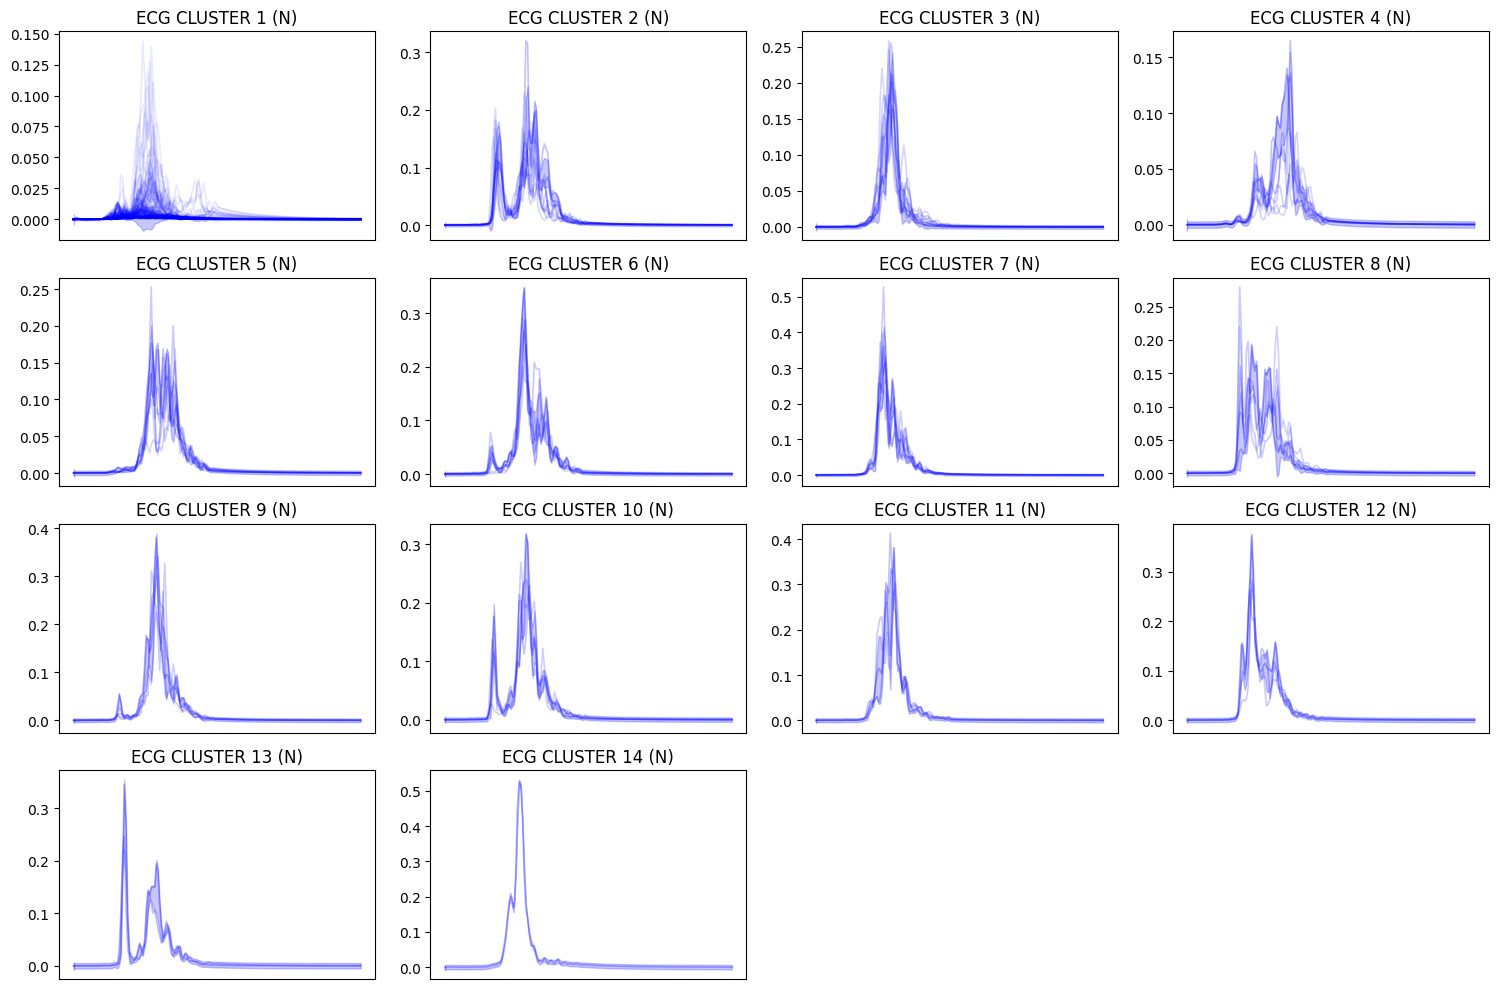

In [26]:
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=0.5, plot_latent=True)

Of course, depending on the nature of the record to cluster, the hyperparameters can be tuned. First consideration should be focused on determining if the record is benefited of a dynamic clustering or not. In the case the patterns exhibit a dynamic change while remaining in the same category it will be interesting to priorize a dynamic behaviour, which is determined making $S_{\omega} > S_{\epsilon}$. If there exist different morphologies with patterns really close one to another, then it will be better to prioritize a static behaviour, with the opposite condition $S_{\omega} < S_{\epsilon}$. 

Once we have the clustering performed, there are parameters of the model which can lead us to interesting insights. For example, the transition matrix represent the probability of jumping from one cluster to another, which can be useful to detect some prevalent loops of behaviour.

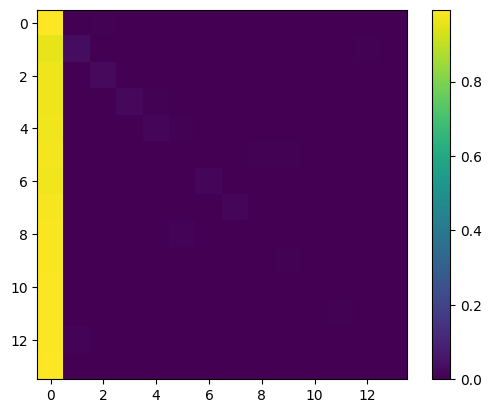

In [28]:
sw_gp.compute_Pi()[:-1,:-1]
plt.imshow(sw_gp.compute_Pi()[:-1,:-1])
plt.colorbar()
plt.show()

Also, visualizing the dynamic parameters can be useful in some cases:

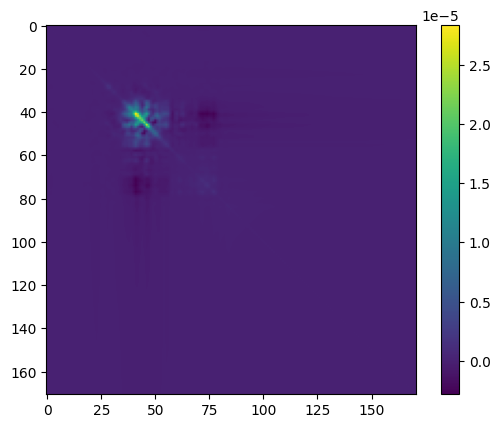

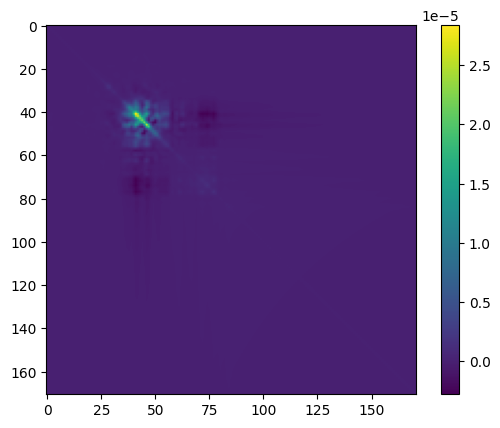

In [29]:
plt.imshow(sw_gp.gpmodels[0][0].Gamma[-1])
plt.colorbar()
plt.show()
plt.imshow(sw_gp.gpmodels[0][0].Sigma[-1])
plt.colorbar()
plt.show()

Usually, the dynamic transformation matrices $A, C$ are really close to the identity due to the conditions they have to satisfy (they have to be stable). So, sometimes is better to represent the transformation they produce in a vector of ones.

[]

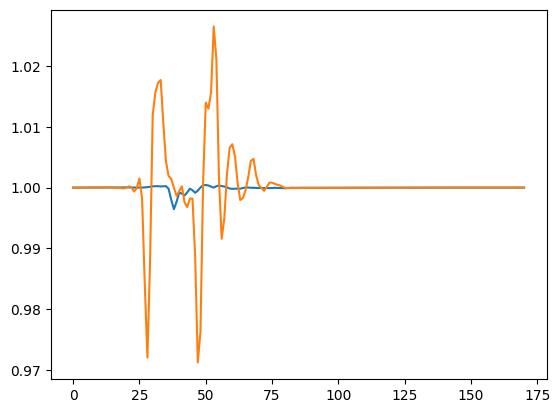

In [30]:
plt.plot(torch.matmul(sw_gp.gpmodels[0][0].A[-1], torch.ones(x_basis.shape[0])))
plt.plot(torch.matmul(sw_gp.gpmodels[0][1].A[-1], torch.ones(x_basis.shape[0])))
plt.plot()

Here we can see how even if the normality clusters seems really similar, the underlying dynamic transformation is really different. Also, we can use the Kullback-Leibler divergence to measure the similarity of the models during their evolution and then represent this distances using a MDS reduction.

In [ ]:
from hdpgpc.util_plots import plot_MDS_plotly
plot_MDS_plotly(sw_gp, main_model, labels, N_0=0, save=None)
plt.show()